#  <p style="text-align: center;">NATURAL LANGUAGE PROCESSING [NLP]: TWITTER US AIRLINE SENTIMENT

**Objective:** The goal of this mini-project is to classify airline tweets as positive, neutral, or negative using a pre-trained word embedding from GloVe and a RNN. 

**Context:** A sentiment analysis job about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service").

###  Load the Libraries:

In [1]:
# Numerical and data libraries
import pandas as pd
import numpy as np

# importing ploting libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

#remove html tags
from bs4 import BeautifulSoup

#remove special characters
import re

#tokenization
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords                       # Import stopwords.
from nltk.tokenize import word_tokenize, sent_tokenize  # Import Tokenizer.
from nltk.stem.wordnet import WordNetLemmatizer         # Import Lemmatizer.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

###  Import data files and load the dataset: 

In [2]:
raw_df = pd.read_csv('Tweets.csv')

Print first 5 rows of data after loading the dataset:

In [3]:
raw_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


### Data Quality Checks:

Check the Dimension of data:

In [4]:
raw_df.shape

(14640, 15)

There are 14,640 tweets within the data, each with 15 features. Let’s take a look at what features this dataset contains.

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


## EXPLORATORY DATA ANALYTICS (EDA)

Let's explore the number of tweets for each airline:

In [6]:
print("Total number of tweets for each airline",raw_df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))
airlines= ['US Airways','United','American','Southwest','Delta','Virgin America']

Total number of tweets for each airline airline
United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


**Visualise number of Tweets for each airline:**

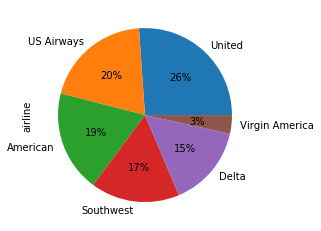

In [7]:
raw_df.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')


**Visualise distribution of sentiment across all airlines:**

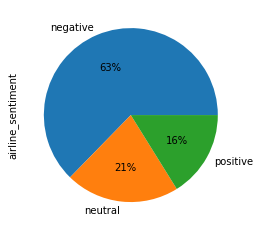

In [8]:
raw_df.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')

**Examine sentiments expressed for each airline:**

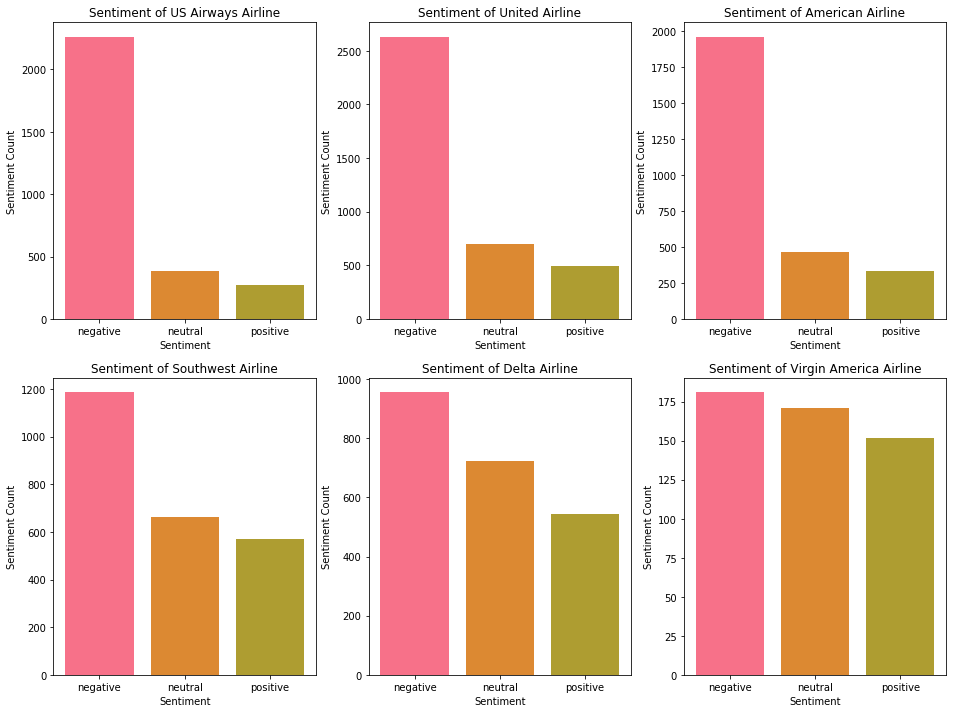

In [9]:
plt.figure(1,figsize=(16, 12))
colors = sns.color_palette('husl',10)

for i in airlines:
    indices= airlines.index(i)
    plt.subplot(2,3,indices+1)
    new_df=raw_df[raw_df['airline']==i]
    count=new_df['airline_sentiment'].value_counts()
    Index = [1,2,3]
    plt.bar(Index,count, color=colors)
    plt.xticks(Index,['negative','neutral','positive'])
    plt.ylabel('Sentiment Count')
    plt.xlabel('Sentiment')
    plt.title('Sentiment of '+i + ' Airline')

Every airline has more negative tweets than either neutral or positive tweets, with Virgin America receiving the most balanced spread of positive, neutral and negative of all the US airlines. United, US Airways, and American airlines received substantially more negative sentiment.

### EDA Negative Sentiment Reasons per Airline

Lets try and visualize the reasons for negative tweets first!

**The top 5 negative reasons:**

In [10]:
raw_df.negativereason.value_counts().sort_values(ascending=False).head(5)

Customer Service Issue    2910
Late Flight               1665
Can't Tell                1190
Cancelled Flight           847
Lost Luggage               724
Name: negativereason, dtype: int64

**Visualize negaive reasons per airline:**

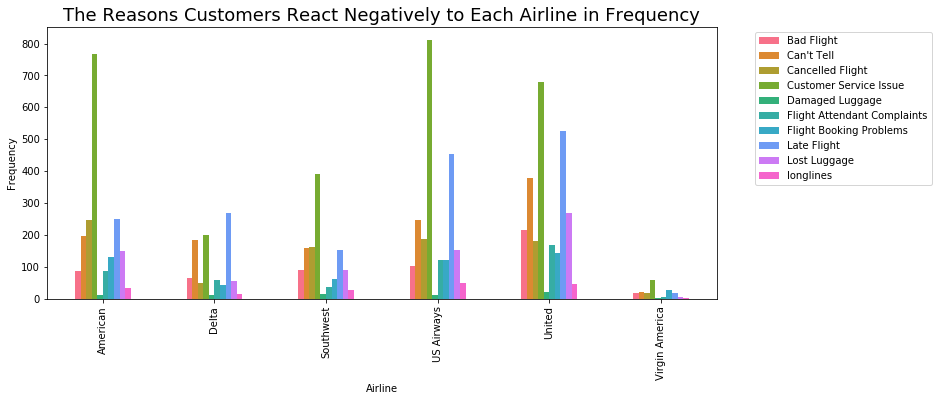

In [11]:
colors = sns.color_palette('husl',10)
pd.crosstab(raw_df.airline, raw_df.negativereason).plot(kind='bar',color=colors,figsize=(12,5))
plt.title('The Reasons Customers React Negatively to Each Airline in Frequency', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Customer Service Issue is the main neagtive reason for US Airways,United,American,Southwest,Virgin America
Late Flight is the main negative reason for Delta

**Wordcloud for Negative sentiments of tweets**

Sentiment analysis can also discover the most frequently used words among positive or negative tweets. In the wordcloud visualisation below, the larger the size of the word indicates the higher frequency of the word appearing in a set of negative tweets. 

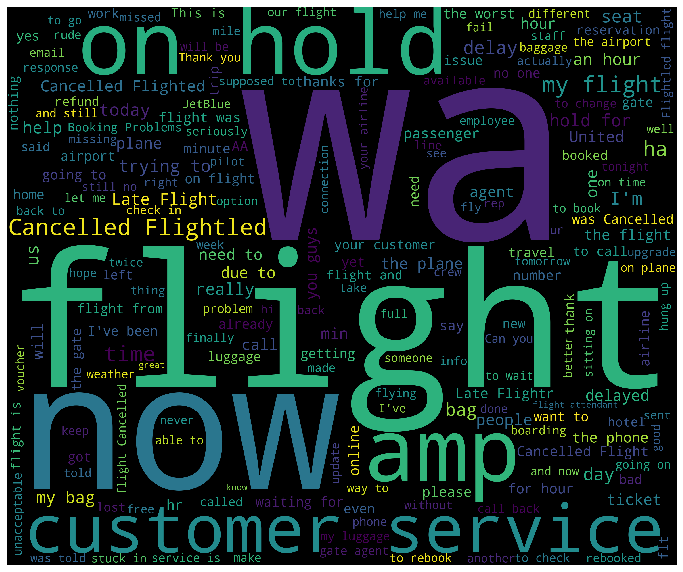

In [12]:
new_df=raw_df[raw_df['airline_sentiment']=='negative']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Words and phrases such as 'cancelled flight', 'delay', 'late flight' , 'luggage', 'hold' and 'customer service' are understandably displayed as the most frequent words witin **Negative tweets**. 

### EDA Positive Sentiment Reasons per Airline

In the wordcloud visualisation below, the larger the size of the word indicates the higher frequency of the word appearing in a set of positive tweets. 

**Wordcloud for Positive sentiments of tweets**

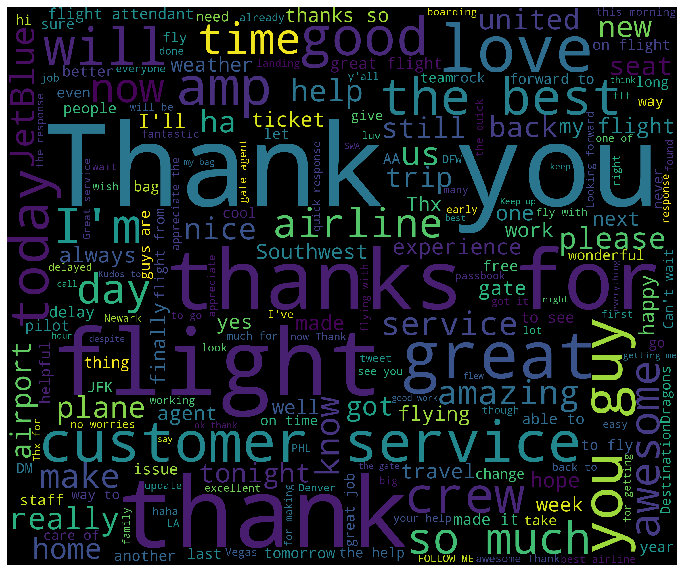

In [13]:
new_df=raw_df[raw_df['airline_sentiment']=='positive']
words = ' '.join(new_df['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Words and phrases such as 'thanks', 'best', 'customer' , 'love', 'awesome' , 'flying' , 'good' are understandably displayed as the most frequent words witin **Positive tweets**. However, other than these, most of the words are stop words and need to be filtered. We will do so later when we clean the data during pre-processing.

## UNDERSTAND THE DATA COLUMNS:

Let’s create a new dataframe with only the text body of the tweet and the airline_sentiment features:

In [14]:
tweet_df = raw_df[['text', 'airline_sentiment']]

Check the Dimension of data:

In [15]:
tweet_df.shape

(14640, 2)

Let's print the first 5 rows of data:

In [16]:
tweet_df.head()

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


## NLP  PRE-PROCESSING TWITTER DATA

The preprocessing of the text data is an essential step as it makes the raw text ready for mining. We must conduct some basic steps of text preprocessing in order to transfer text from human language to a machine readable format so that it becomes easier to extract information from the text and apply machine learning algorithms to it for further processing.

#### Html Tag Removal:

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

tweet_df['text'] = tweet_df['text'].apply(lambda x: strip_html(x))

#### Remove the numbers:

We also get rid of the numbers since they add no value in differentiating sentiment within different kinds of tweets.

In [18]:
def remove_numbers(text):
  text = re.sub(r'\d+', '', text)
  return text

tweet_df['text'] = tweet_df['text'].apply(lambda x: remove_numbers(x))

#### Tokenization:
Now we will tokenize all the cleaned tweets in our dataset. Tokens are individual terms or words, and tokenization is the process of splitting a string of text into tokens.

In [19]:
tweet_df['text'] = tweet_df.apply(lambda row: nltk.word_tokenize(row['text']), axis=1) # Tokenization of data

#### Removal of Special Characters and Punctuations:

We also get rid of the punctuations and even special characters since they wouldn’t help in differentiating different kinds of tweets.

In [20]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    tweet_cleans = []
    for word in words:
        tweet_clean = re.sub(r'[^\w\s]', '', word)
        if tweet_clean != '':
            tweet_cleans.append(tweet_clean)
    return tweet_cleans

#### Conversion to lowercase:
We need to eliminate discrepancies between texts that may exist only due case sensitive versions of tweet texting language. To do this we will convert all text to lowercase. 

In [21]:
def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    tweet_cleans = []
    for word in words:
        tweet_clean = word.lower()
        tweet_cleans.append(tweet_clean)
    return tweet_cleans

#### Perform Lemmatize or stemming:
Stemming is a rough process by which variants or related forms of a word are reduced (stemmed) to a common base forms via the removal of prefixed or suffixed letters from a word, the output may or may not be a word belonging to the language corpus. 

Lemmatization is a more precise process by which words are properly reduced to the base word from which they came. We will elect to use Lemmatization to opt for the more precise approach. 

In [22]:
lemmatizer = WordNetLemmatizer()

def lemmatize_list(words):
    tweet_cleans = []
    for word in words:
       tweet_cleans.append(lemmatizer.lemmatize(word, pos='v'))
    return  tweet_cleans

#### Stopword Removal

Most of the smaller words do not add much value. For example ‘his’, ‘all’, 'if' and many otheres. Thus we remove them as well from our data. However some small words such as 'no' and 'not'  might indicate a certain sentiment and must be kept 

In [23]:
def remove_stopwords(words):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    tweet_cleans = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return (tweet_cleans)

**Join the words in the list to convert back to text string in the dataframe:**

In [24]:
def normalize(words):
    words = remove_punctuation(words)
    words = to_lowercase(words)
    words = lemmatize_list(words)
    words = remove_stopwords(words)
    return ' '.join(words)

#### Print first 5 rows of data after pre-processing:

In [25]:
tweet_df['text'] = tweet_df.apply(lambda row: normalize(row['text']), axis=1)
tweet_df.head()

,text,airline_sentiment
0,virginamerica dhepburn say,neutral
1,virginamerica plus add commercials experience ...,positive
2,virginamerica nt today must mean need take ano...,neutral
3,virginamerica really aggressive blast obnoxiou...,negative
4,virginamerica really big bad thing,negative


You can see the difference between the raw tweets and the cleaned tweets (tweet_df) quite clearly. Only the important words in the tweets have been retained and the noise (numbers, punctuations, and special characters) has been removed.

### Spitting the Data between target and independant variables:

Let’s separate our predictors (X) from our target variable (y):

In [26]:
# Separate features and target
X = tweet_df['text']
y = tweet_df['airline_sentiment'] 

## REPRESENTING TEXT IN NUMERIC FORM [VECTORIZATION]

Statistical algorithms use mathematics to train machine learning models. Machine learning models work with numbers only, thus to make statistical algorithms work with text, we first have to convert text to numbers. To do so, we will apply both the Bag of Words and TF-IDF and approaches. 

**Bag of words: CountVectorizer**

In the bag of words approach the first step is to create a vocabulary of all the unique words. Next each document is converted into a feature vector using the vocabulary. The length of each feature vector is equal to the length of the vocabulary. The frequency of the word in the document will replace the actual word in the vocabulary. 

In [27]:
CountVectorizer = CountVectorizer(analyzer = "word")
CV_X = CountVectorizer.fit_transform(X)

In [28]:
print(CountVectorizer.vocabulary_)

{'virginamerica': 11493, 'dhepburn': 2580, 'say': 8348, 'plus': 7354, 'add': 134, 'commercials': 1888, 'experience': 3298, 'tacky': 9325, 'nt': 6700, 'today': 10849, 'must': 6324, 'mean': 5940, 'need': 6415, 'take': 9337, 'another': 475, 'trip': 10998, 'really': 7799, 'aggressive': 208, 'blast': 1069, 'obnoxious': 6742, 'entertainment': 3102, 'guests': 4195, 'face': 3343, 'little': 5577, 'recourse': 7845, 'big': 1020, 'bad': 800, 'thing': 10712, 'seriously': 8497, 'would': 11904, 'pay': 7117, 'flight': 3569, 'seat': 8425, 'play': 7318, 'fly': 3644, 'va': 11391, 'yes': 12003, 'nearly': 6411, 'every': 3208, 'time': 10796, 'vx': 11543, 'ear': 2916, 'worm': 11879, 'win': 11789, 'go': 4039, 'away': 757, 'miss': 6143, 'prime': 7540, 'opportunity': 6869, 'men': 6001, 'without': 11820, 'hat': 4289, 'parody': 7056, 'https': 4572, 'tcomwpggrezp': 9969, 'well': 11672, 'didntbut': 2595, 'amaze': 368, 'arrive': 598, 'hour': 4538, 'early': 2919, 'good': 4066, 'know': 5305, 'suicide': 9171, 'second':

In [29]:
print(CV_X.shape)

(14640, 12085)


**TF-IDF Features:**

This is another method which is based on the frequency method but it is different to the bag-of-words approach in the sense that it takes into account, not just the occurrence of a word in a single document (or tweet) but in the entire document dataset. In the bag of words approach, each word has the same weight. The idea behind the TF-IDF approach is that the words that occur less in all the documents and more in individual document contribute more towards classification.

TF-IDF works by assigning lower weights to the common words whilst giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

In [30]:
Tfidfvectorizer = TfidfVectorizer()
Tfidf_X = Tfidfvectorizer.fit_transform(X).toarray()

In [31]:
print(Tfidfvectorizer.vocabulary_)

{'virginamerica': 11493, 'dhepburn': 2580, 'say': 8348, 'plus': 7354, 'add': 134, 'commercials': 1888, 'experience': 3298, 'tacky': 9325, 'nt': 6700, 'today': 10849, 'must': 6324, 'mean': 5940, 'need': 6415, 'take': 9337, 'another': 475, 'trip': 10998, 'really': 7799, 'aggressive': 208, 'blast': 1069, 'obnoxious': 6742, 'entertainment': 3102, 'guests': 4195, 'face': 3343, 'little': 5577, 'recourse': 7845, 'big': 1020, 'bad': 800, 'thing': 10712, 'seriously': 8497, 'would': 11904, 'pay': 7117, 'flight': 3569, 'seat': 8425, 'play': 7318, 'fly': 3644, 'va': 11391, 'yes': 12003, 'nearly': 6411, 'every': 3208, 'time': 10796, 'vx': 11543, 'ear': 2916, 'worm': 11879, 'win': 11789, 'go': 4039, 'away': 757, 'miss': 6143, 'prime': 7540, 'opportunity': 6869, 'men': 6001, 'without': 11820, 'hat': 4289, 'parody': 7056, 'https': 4572, 'tcomwpggrezp': 9969, 'well': 11672, 'didntbut': 2595, 'amaze': 368, 'arrive': 598, 'hour': 4538, 'early': 2919, 'good': 4066, 'know': 5305, 'suicide': 9171, 'second':

In [32]:
print(Tfidf_X.shape)

(14640, 12085)


### Dividing Data into Training and Test Sets:

In [33]:
from sklearn.model_selection import train_test_split

#Split the CountVectorizer data into 'Training' and 'Test' sets:
CV_X_train, CV_X_test, CV_y_train, CV_y_test = train_test_split(CV_X, y, test_size=0.2, random_state=0)

#Split the IF_IDF data into 'Training' and 'Test' sets:
Tfidf_X_train, Tfidf_X_test, Tfidf_y_train, Tfidf_y_test = train_test_split(Tfidf_X, y, test_size=0.2, random_state=0)

## BUILDING THE CLASSIFICATION MODEL(s):

Load the Machine Learning Libraries:

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB

#Evaluate the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix

We will compare six popular classification methods including Simple LogisticRegression, KNeighborsClassifier, Support Vector Machine (SVM) classifier, Decision Tree classifier, AdaBoost classifier and Random Forest classifier. 

In [35]:
Classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=200),
    AdaBoostClassifier(),
    LinearSVC()]

**Training and Fitting the classification Model(s) - on the CountVectorizer data:**

In [36]:
CV_Accuracy=[]
CV_Model=[]

for classifier in Classifiers:
    CV_fit = classifier.fit(CV_X_train,CV_y_train)
    CV_pred = CV_fit.predict(CV_X_test)
    accuracy = accuracy_score(CV_pred,CV_y_test)
    CV_Accuracy.append(accuracy)
    CV_Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy*100)+'%')

Accuracy of LogisticRegression is 79.43989071038251%
Accuracy of KNeighborsClassifier is 50.75136612021858%
Accuracy of DecisionTreeClassifier is 72.09699453551912%
Accuracy of RandomForestClassifier is 77.42486338797814%
Accuracy of AdaBoostClassifier is 74.4535519125683%
Accuracy of LinearSVC is 76.98087431693989%


**Evaluate Model(s) trained on CountVectorize Data:**

The performance of different popular sentiment classification approaches were evaluated on the TF_IDF data. The best results from the below popular classification methods on the test data were as follows: 

- LogisticRegression:79.5%
- KNeighbors Classifier: 50.75%
- DecisionTreeClassifier: 72.1%
- RandomForest Classifier: 77.42%
- AdaBoost Classifier: 74.45%
- Linear SVC Classifier: 77%

The best performing model is surprisingly the LogisticRegression model with an accuracy score of 79.5%. It is not surprising that the KNeighbors Classifier was by far the worst performer. 

**Training and Fitting the classification Model(s) - on the TF_IDF data:**

In [37]:
Tfidf__Accuracy=[]
Tfidf_Model=[]

for classifier in Classifiers:
    Tfidf_fit = classifier.fit(Tfidf_X_train,Tfidf_y_train)
    Tfidf_pred = Tfidf_fit.predict(Tfidf_X_test)
    accuracy = accuracy_score(Tfidf_pred,Tfidf_y_test)
    Tfidf__Accuracy.append(accuracy)
    Tfidf_Model.append(classifier.__class__.__name__)
    print('Accuracy of '+classifier.__class__.__name__+' is '+str(accuracy*100)+'%')

Accuracy of LogisticRegression is 79.03005464480874%
Accuracy of KNeighborsClassifier is 69.91120218579235%
Accuracy of DecisionTreeClassifier is 69.94535519125684%
Accuracy of RandomForestClassifier is 77.62978142076503%
Accuracy of AdaBoostClassifier is 74.00956284153006%
Accuracy of LinearSVC is 78.96174863387978%


**Evaluate Model trained on TF_IDF Data:**

The performance of different popular sentiment classification approaches were evaluated on the TF_IDF data. The best results from the below popular classification methods on the test data were as follows: 

- LogisticRegression:79.03%
- KNeighbors Classifier:69.91%
- DecisionTreeClassifier:69.94%
- RandomForest Classifier:77.63%
- AdaBoost Classifier:74.00%
- Linear SVC Classifier:78.96%

The best performing model is still surprisingly the LogisticRegression model, however it is observed that Random Forest along with  Linear SVM model also performed well. 

**Performance on CountVectorize Data versus TF_IDF:**
Our results show negligible improved performance on average for the models fitted using the 'Bag of Words' approach over the TF_IDF method approach. This indicates that Twitter sentiment comments may be generic in nature and thus it may be detrimental to favour statistically ‘unique’ or less frequently occurring words as valuable sentiment analysis is also derived from frequently used words. 

## Visualise of Comparison of Model Accuracy Results on Test data:

**Performance of the classification Model(s) - on the CountVectorizer data:**

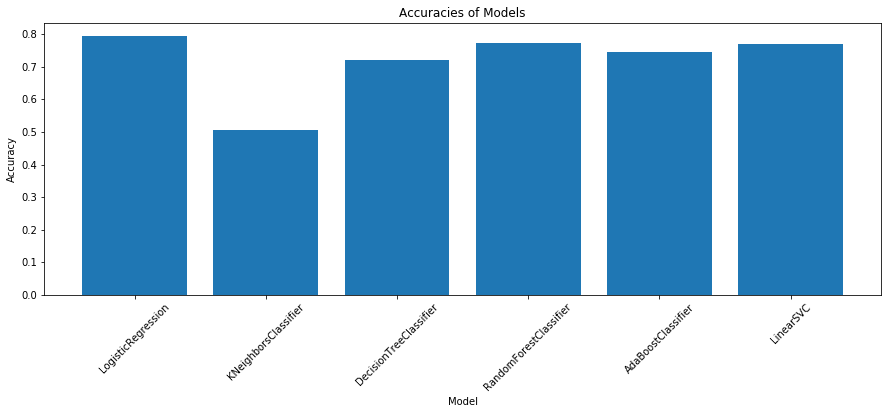

In [38]:
plt.figure(figsize=(15,5))
Index = [1,2,3,4,5,6]
plt.bar(Index,CV_Accuracy)
plt.xticks(Index, CV_Model, rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show()

**Performance of the classification Model(s) - on the TF_IDF data data:**

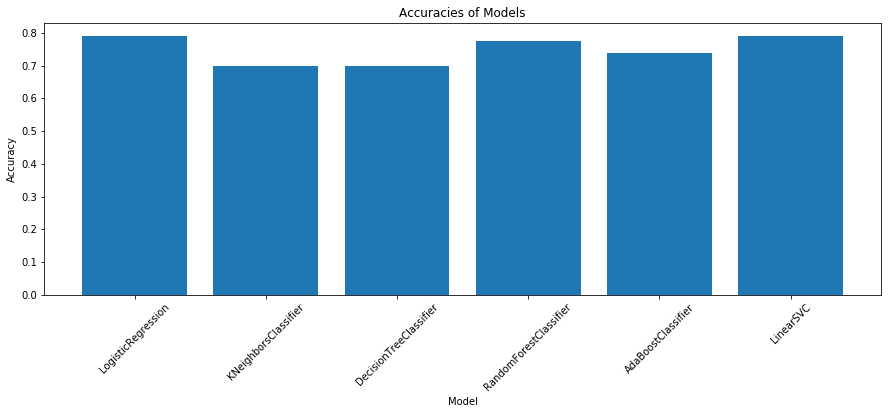

In [39]:
plt.figure(figsize=(15,5))
Index = [1,2,3,4,5,6]
plt.bar(Index,Tfidf__Accuracy)
plt.xticks(Index, Tfidf_Model, rotation=45)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.title('Accuracies of Models')
plt.show()

## Naïve Bayesian Classifier Model

Naïve Bayesian Classifier - We shall also try the Naïve Bayesian Classifier, owing to its ability to act on multi classification of non-normalized data.

In [40]:
NB_model = MultinomialNB()

**Training the Model - on the CountVectorizer data:**

In [41]:
NB_model.fit(CV_X_train, CV_y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

Once the model has been trained, the last step is to make predictions on the model. 

In [42]:
predictions_NB = NB_model.predict(CV_X_test)

**Evaluate Model trained on CountVectorize Data:**

In [43]:
print('Accuracy of Naive Bayes Classifier is:', round(100 * NB_model.score(CV_X_test, CV_y_test), 2), '%')

Accuracy of Naive Bayes Classifier is: 76.81 %


<Figure size 432x288 with 0 Axes>

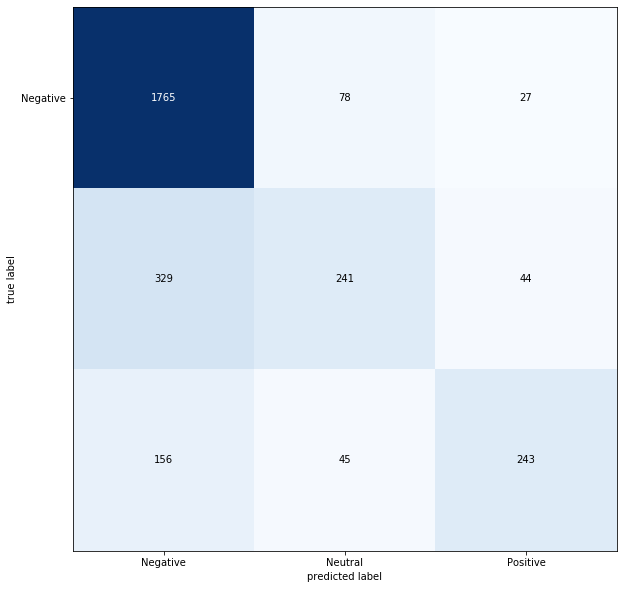

In [44]:
cm_cv = confusion_matrix(CV_y_test,predictions_NB)
plt.figure()
plot_confusion_matrix(cm_cv,figsize=(10,10), hide_ticks=True, cmap = None)
plt.xticks(range(3), ['Negative', 'Neutral', 'Positive'], fontsize=10, color='black')
plt.yticks(range(1), ['Negative', 'Neutral', 'Positive'], fontsize=10, color='black')
plt.show()

In [45]:
print(classification_report(CV_y_test,predictions_NB))

              precision    recall  f1-score   support

    negative       0.78      0.94      0.86      1870
     neutral       0.66      0.39      0.49       614
    positive       0.77      0.55      0.64       444

    accuracy                           0.77      2928
   macro avg       0.74      0.63      0.66      2928
weighted avg       0.76      0.77      0.75      2928



# FINAL ANALYSIS OF RESULTS:

An sentiment analysis model evaluation has been implemented in the research by using the open NLP libraries. The performance of different popular sentiment classification approaches were evaluated. 

The best results from the below popular classification methods on the test data were as follows: 

- Random Forest: 77.63%
- Decision Tree: 72.1%
- AdaBoost: 78.6%
- Linear SVM: 78.5%
- Naïve Bayesian Classifier: 76.81%
- KNeighborsClassifier: 69.91%
- LogisticRegression: 79.5%

From the above table of results, it is observed that Random Forest along with  Linear SVM and LogisticRegression performed well. 

The best performing model is surprisingly the LogisticRegression model with an accuracy score of 79.5%.

From the confusion matrix, we can see that there were quite a few samples that we predicted negative, when they were actually neutral. Thus, the model is slightly biased towards predicting a negative sentiment: this might have to do with the fact that there are so many negative Tweets in the first place.

Overall, our accuracy results were good and the results are very encouraging. This is likely due to and effective pre-processing of data performed. Furthermore, our fine-tuning process was simple and computationally efficient.

There is still scope for improvement in this analysis. Other approaches we can try to improve our sentiment analysis include: 
- Experiment with only and 'Positive' and 'Negative' binary class sentiment analysis. 
- Up-sample the Dataset
- Try build a Neural Network to perform the sentiment analysis. 

We show how the proposed machine learning models applied to sentiment analysis can be used to compute corporate reputation for the major US airlines and provide valuable customer insight.

#### END OF PROJECT - TWITTER US AIRLINE SENTIMENT PREDICTION!